
Found 4436 images belonging to 2 classes.
Found 554 images belonging to 2 classes.
Found 556 images belonging to 2 classes.


Epoch 1/100


139/139 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.8787

C:\Users\ABDULLAH AL KAWSER\pythonlab\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 370s 3s/step - loss: 0.2905 - accuracy: 0.8787 - val_loss: 0.1867 - val_accuracy: 0.9278 - lr: 1.0000e-04
Epoch 2/100
139/139 [==============================] - 335s 2s/step - loss: 0.1553 - accuracy: 0.9396 - val_loss: 0.1168 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 3/100
139/139 [==============================] - 320s 2s/step - loss: 0.1269 - accuracy: 0.9518 - val_loss: 0.1169 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 4/100
139/139 [==============================] - 298s 2s/step - loss: 0.1116 - accuracy: 0.9549 - val_loss: 0.0916 - val_accuracy: 0.9729 - lr: 1.0000e-04
Epoch 5/100
139/139 [==============================] - 296s 2s/step - loss: 0.0984 - accuracy: 0.9657 - val_loss: 0.1010 - val_accuracy: 0.9585 - lr: 1.0000e-04
Epoch 6/100
139/139 [==============================] - 311s 2s/step - loss: 0.0898 - accuracy: 0.9718 - val_loss: 0.0793 - val_accuracy: 0.9747 - lr: 1.0000e-04
Epoch 7/100
139/139 [=========================

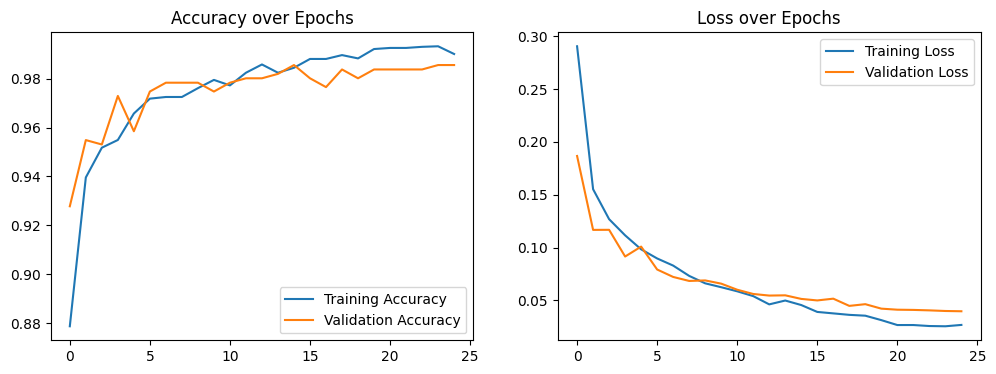

Model and class indices have been saved.


In [1]:
import os
import datetime
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121

def create_densenet_model(num_classes):
    base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Paths for your dataset
base_dir = r'E:\NURU_DATA\DATA_AUG\Project_Final'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

# Data generators without data augmentation
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

# Number of classes
num_classes = len(train_generator.class_indices)

# Create and compile the model
model = create_densenet_model(num_classes)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Compute class weights for imbalanced datasets
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Callbacks
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model_densenet.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model in the Keras format
model_path = os.path.join(base_dir, 'model', 'my_model_densenet.h5')
model.save(model_path)

# Save the class indices to a json file
class_indices = train_generator.class_indices
class_indices_path = os.path.join(base_dir, 'model', 'class_indices_densenet.json')
with open(class_indices_path, 'w') as json_file:
    json.dump(class_indices, json_file)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

print("Model and class indices have been saved.")